In [1]:
import numpy as np
import pickle
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
from ipywidgets import interact, IntSlider

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
len(train_data)

994

In [5]:
type(train_data[0])

tuple

In [6]:
train_data[0][0].shape

(300, 165)

In [250]:
50/32

1.5625

In [6]:
with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [7]:
len(test_data)

253

In [242]:
val_data = test_data[:0.10*len(test_data)]

TypeError: slice indices must be integers or None or have an __index__ method

In [251]:
class DD100(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_follower = data_point[0]
        data_leader = data_point[1]
        return data_leader, data_follower


In [252]:
train_dataset = DD100(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [253]:
test_dataset = DD100(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [255]:
for data in train_dataloader:
    print(data[0].shape, data[1].shape)
    break

torch.Size([32, 300, 165]) torch.Size([32, 300, 165])


In [221]:
for data in test_dataloader:
    print(data[0].shape, data[1].shape)
    break

torch.Size([32, 300, 165]) torch.Size([32, 300, 165])


In [222]:
# Function to plot the skeleton
def plot_skeleton(joints, ax, c, joint_names):
    # Define the connections between joints
    skeleton_connections = [
        ('pelvis', 'spine1'),('pelvis', 'right_hip'), ('pelvis','left_hip'), ('spine1', 'spine2'), ('spine2', 'spine3'), ('spine3', 'neck'),
        ('neck', 'head'), ('spine3', 'left_collar'), ('spine3', 'right_collar'),
        ('left_collar', 'left_shoulder'), ('right_collar', 'right_shoulder'),
        ('left_shoulder', 'left_elbow'), ('right_shoulder', 'right_elbow'),
        ('left_elbow', 'left_wrist'), ('right_elbow', 'right_wrist'),
        ('left_hip', 'left_knee'), ('right_hip', 'right_knee'),
        ('left_knee', 'left_ankle'), ('right_knee', 'right_ankle'),
        ('left_ankle', 'left_foot'), ('right_ankle', 'right_foot'),
        ('head', 'jaw'), ('jaw', 'left_eye_smplhf'), ('jaw', 'right_eye_smplhf'),
        ('left_wrist', 'left_thumb1'), ('left_wrist', 'left_index1'), ('left_wrist', 'left_middle1'),
        ('left_wrist', 'left_ring1'), ('left_wrist', 'left_pinky1'),
        ('right_wrist', 'right_thumb1'), ('right_wrist', 'right_index1'), ('right_wrist', 'right_middle1'),
        ('right_wrist', 'right_ring1'), ('right_wrist', 'right_pinky1'), ('left_thumb1', 'left_thumb2'),
        ('left_index1', 'left_index2'), ('left_middle1', 'left_middle2'), ('left_ring1', 'left_ring2'),
        ('left_pinky1', 'left_pinky2'), ('right_thumb1', 'right_thumb2'), ('right_index1', 'right_index2'),
        ('right_middle1', 'right_middle2'), ('right_ring1', 'right_ring2'), ('right_pinky1', 'right_pinky2'),
        ('left_thumb2', 'left_thumb3'), ('left_index2', 'left_index3'), ('left_middle2', 'left_middle3'),
        ('left_ring2', 'left_ring3'), ('left_pinky2', 'left_pinky3'), ('right_thumb2', 'right_thumb3'),
        ('right_index2', 'right_index3'), ('right_middle2', 'right_middle3'), ('right_ring2', 'right_ring3'),
        ('right_pinky2', 'right_pinky3')
    ]

    # Convert joint names to indices
    joint_indices = {name: i for i, name in enumerate(joint_names)}

    for joint1_name, joint2_name in skeleton_connections:
        joint1_index = joint_indices[joint1_name]
        joint2_index = joint_indices[joint2_name]

        joint1 = joints[joint1_index]
        joint2 = joints[joint2_index]

        ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], [joint1[2], joint2[2]], color=c)

In [223]:
def vis_one_data_point(leader, follower, coords_details):
    ''' leader and follower should have shapes (T, 165) '''
    ''' will visualize a single data_point '''  
    # Example data
    T = leader.shape[0]  # Number of frames

    # if joints_data is a tensor, convert
    if torch.is_tensor(leader):
        joints_data = leader.reshape(-1, 55, 3).detach().cpu().numpy()
        joints_data_cond = follower.reshape(-1, 55, 3).detach().cpu().numpy()
    else:
        joints_data = leader.reshape(-1, 55, 3)
        joints_data_cond = follower.reshape(-1, 55, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # List of joint names
    joint_names = [
        'pelvis', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee',
        'spine2', 'left_ankle', 'right_ankle', 'spine3', 'left_foot', 'right_foot',
        'neck', 'left_collar', 'right_collar', 'head', 'left_shoulder',
        'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
        'jaw', 'left_eye_smplhf', 'right_eye_smplhf', 'left_index1', 'left_index2',
        'left_index3', 'left_middle1', 'left_middle2', 'left_middle3',
        'left_pinky1', 'left_pinky2', 'left_pinky3', 'left_ring1', 'left_ring2',
        'left_ring3', 'left_thumb1', 'left_thumb2', 'left_thumb3', 'right_index1',
        'right_index2', 'right_index3', 'right_middle1', 'right_middle2',
        'right_middle3', 'right_pinky1', 'right_pinky2', 'right_pinky3',
        'right_ring1', 'right_ring2', 'right_ring3', 'right_thumb1',
        'right_thumb2', 'right_thumb3'
    ]

    def plot_frame(t):
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        
        # Plot joints
        ax.scatter(joints_data[t, :, 0], joints_data[t, :, 1], joints_data[t, :, 2], c='r')
        ax.scatter(joints_data_cond[t, :, 0], joints_data_cond[t, :, 1], joints_data_cond[t, :, 2], c='b')
        
        # Plot skeleton
        plot_skeleton(joints_data[t], ax, 'r', joint_names)
        plot_skeleton(joints_data_cond[t], ax, 'b', joint_names)

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Skeleton Visualization - Frame {t+1}')

        '''xmin = np.min(joints_data[:, :, 0])
        xmin = min(xmin, np.min(joints_data_cond[:, :, 0]))
        xmax = np.max(joints_data[:, :, 0])
        xmax = max(xmax, np.max(joints_data_cond[:, :, 0]))
        ymin = np.min(joints_data[:, :, 1])
        ymin = min(ymin, np.min(joints_data_cond[:, :, 1]))
        ymax = np.max(joints_data[:, :, 1])
        ymax = max(ymax, np.max(joints_data_cond[:, :, 1]))
        zmin = np.min(joints_data[:, :, 2])
        zmin = min(zmin, np.min(joints_data_cond[:, :, 2]))
        zmax = np.max(joints_data[:, :, 2])
        zmax = max(zmax, np.max(joints_data_cond[:, :, 2]))'''

        xmin = coords_details['xmin']
        xmax = coords_details['xmax']
        ymin = coords_details['ymin']
        ymax = coords_details['ymax']
        zmin = coords_details['zmin']
        zmax = coords_details['zmax']

        # Set fixed axis limits
        ax.set_xlim([xmin, xmax])  # Adjust xmin and xmax according to your data
        ax.set_ylim([ymin, ymax])  # Adjust ymin and ymax according to your data
        ax.set_zlim([zmin, zmax])  # Adjust zmin and zmax according to your data



    # Function to update the plot for the animation
    def update(t):
        ax.clear()  # Clear the current figure
        plot_frame(t)

    ani = animation.FuncAnimation(fig, update, frames=range(leader.shape[0]), repeat=False)


    return ani
    #ipywidgets.interact(plot_frame, t=ipywidgets.Play(min=0, max=leader.shape[0]-1, step=1, interval=20))

In [224]:
leader, follower = None, None
for data in train_dataloader:
    leader, follower = data
    break

In [225]:
leader.shape, follower.shape

(torch.Size([32, 300, 165]), torch.Size([32, 300, 165]))

In [256]:
for data in train_dataloader:
    leader, follower = data
    print(leader.shape, follower.shape)

torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) torch.Size([32, 300, 165])
torch.Size([32, 300, 165]) t

In [226]:
def vis_results (input, ground_truth, predicted, epoch, path):
    '''
    input: (N, 300, 165)
    ground_truth: (N, 300, 165)
    predicted: (N, 300, 165)
    '''
    input = input.detach().cpu().numpy()
    ground_truth = ground_truth.detach().cpu().numpy()
    predicted = predicted.detach().cpu().numpy()
    num_samples = input.shape[0]
    random_indices = np.random.choice(input.shape[0], size=5, replace=False)
    input = input[random_indices]
    ground_truth = ground_truth[random_indices]
    predicted = predicted[random_indices]
    plot_num_samples = input.shape[0]

    data_concat = np.concatenate([input, ground_truth, predicted], axis=0).reshape(-1, 300, 55, 3)

    xmin = np.min(data_concat[:, :, :, 0])
    xmax = np.max(data_concat[:, :, :, 0])

    ymin = np.min(data_concat[:, :, :, 1])
    ymax = np.max(data_concat[:, :, :, 1])

    zmin = np.min(data_concat[:, :, :, 2])
    zmax = np.max(data_concat[:, :, :, 2])

    coords_details = {'xmin': xmin, 'xmax': xmax, 'ymin': ymin, 'ymax': ymax, 'zmin': zmin, 'zmax': zmax}
    
    print(f'Plotting at epoch {epoch}')
    for i in tqdm(range(plot_num_samples)):
        ani_gt = vis_one_data_point(input[i], ground_truth[i], coords_details)
        ani_pred = vis_one_data_point(input[i], predicted[i], coords_details)
        ani_gt.save(path+f'gt_epoch_{epoch}_{i}.gif', writer=animation.PillowWriter(fps=15))
        ani_pred.save(path+f'pred_epoch_{epoch}_{i}.gif', writer=animation.PillowWriter(fps=15))

    return None


In [227]:
leader.shape

torch.Size([32, 300, 165])

In [228]:
follower.shape

torch.Size([32, 300, 165])

In [229]:
random_gen = torch.from_numpy(np.random.rand(32, 300, 165))

In [230]:
random_gen.shape

torch.Size([32, 300, 165])

Plotting at epoch 0


100%|██████████| 5/5 [12:33<00:00, 150.61s/it]


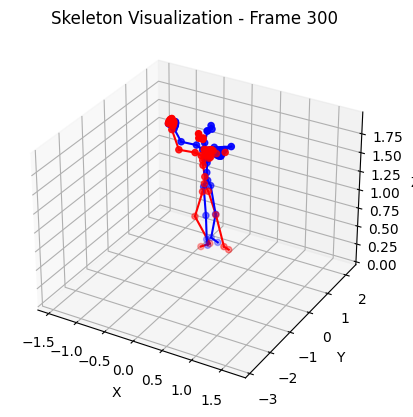

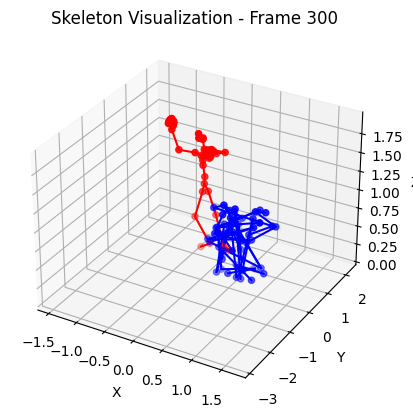

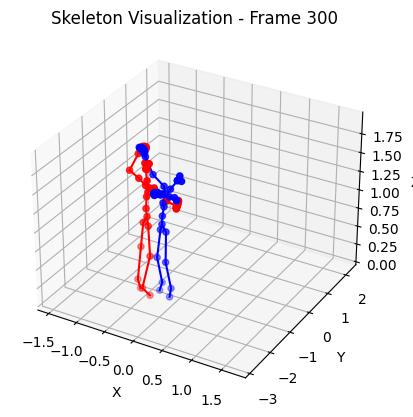

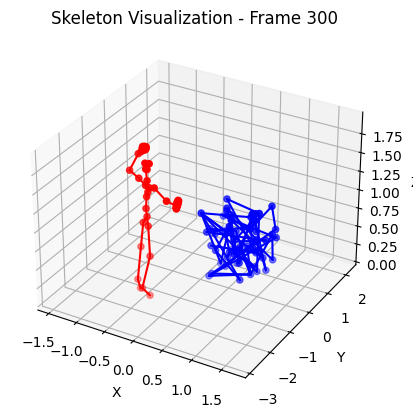

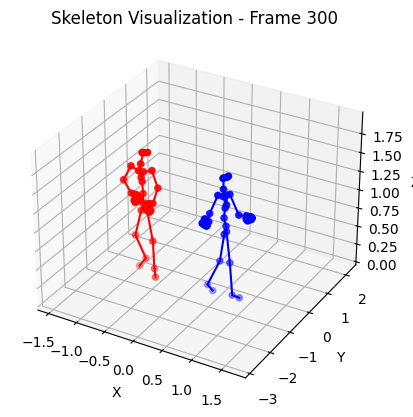

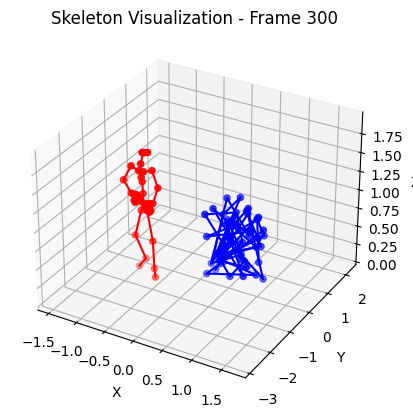

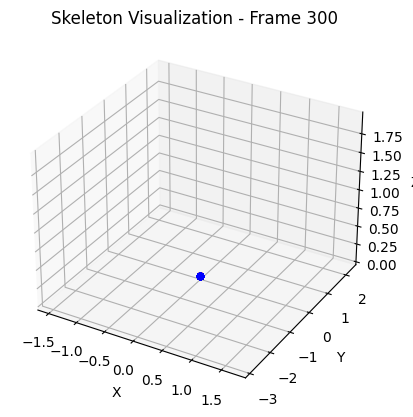

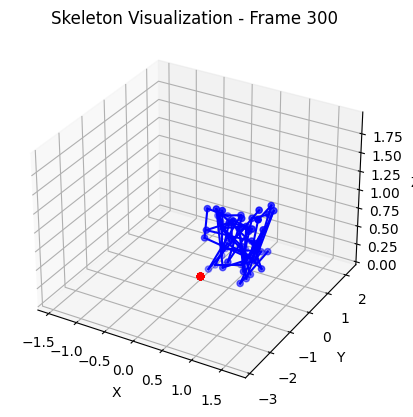

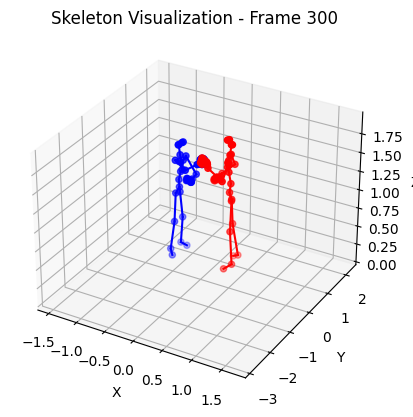

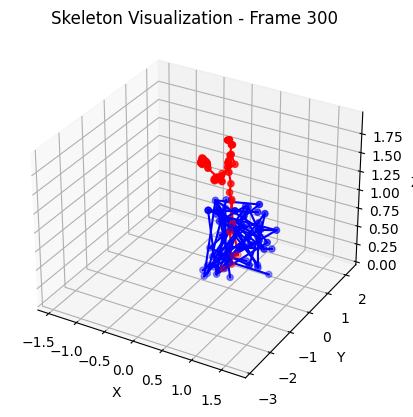

In [231]:
vis_results(leader, follower, random_gen, 0, 'train_gifs/')

In [232]:
joint_names = [
        'pelvis', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee',
        'spine2', 'left_ankle', 'right_ankle', 'spine3', 'left_foot', 'right_foot',
        'neck', 'left_collar', 'right_collar', 'head', 'left_shoulder',
        'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
        'jaw', 'left_eye_smplhf', 'right_eye_smplhf', 'left_index1', 'left_index2',
        'left_index3', 'left_middle1', 'left_middle2', 'left_middle3',
        'left_pinky1', 'left_pinky2', 'left_pinky3', 'left_ring1', 'left_ring2',
        'left_ring3', 'left_thumb1', 'left_thumb2', 'left_thumb3', 'right_index1',
        'right_index2', 'right_index3', 'right_middle1', 'right_middle2',
        'right_middle3', 'right_pinky1', 'right_pinky2', 'right_pinky3',
        'right_ring1', 'right_ring2', 'right_ring3', 'right_thumb1',
        'right_thumb2', 'right_thumb3'
    ]

In [233]:
len(joint_names)

55

In [234]:
def human_loss(data,lamda = 0.0001):
    ''' data is of shape (N, T, J, 3) '''
    right = [(0, 2),(9, 14),(14, 17),(17, 19),(19, 21),(2, 5),(5, 8),(8, 11),(22, 24)
            ,(21, 52),(21, 40),(21, 43),(21, 49),(21, 46),(52, 53),(40, 41),(43, 44),
            (49, 50),(46, 47),(53, 54),(41, 42),(44, 45),(50, 51),(47, 48)]

    left = [(0, 1), (9, 13),(13, 16),(16, 18),(18, 20),(1, 4),(4, 7),(7, 10),
            (22, 23),(20, 37),(20, 25),(20, 28),(20, 34),(20, 31),(37, 38),
            (25, 26),(28, 29),(34, 35),(31, 32),(38, 39),(26, 27),(29, 30),
            (35, 36),(32, 33)]

    error = 0

    for i in range(len(right)):
        error+=(torch.norm(data[:,:,right[i][0]-1,:] - data[:,:,right[i][1]-1,:])\
             - torch.norm(data[:,:,left[i][0]-1,:] - data[:,:,left[i][1]-1,:]))**2
    return lamda*error